In [1]:
!mkdir data
!cp -r '/kaggle/input/workoutexercises-images/squat' data
!cp -r '/kaggle/input/workoutexercises-images/push up' data

In [2]:
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs

In [3]:
# we will use movenet to make a dataset of poses to classify the squat and the pushup

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, duration):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, duration=duration)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

In [5]:
data_dir = '/kaggle/working/data' # we have to sub_dir for each class containing the images

model_name = "movenet_thunder_int8"

module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
input_size = 256
def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

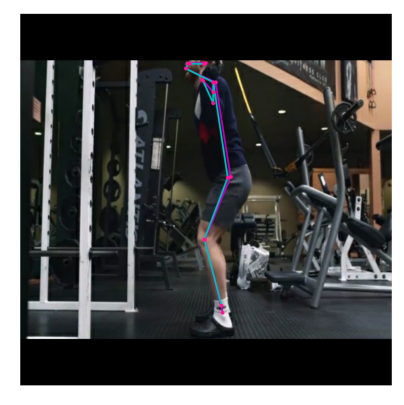

In [6]:
# Load the input image.
image_path = '/kaggle/input/workoutexercises-images/squat/squat_1000021.jpg'
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)

# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

# Run model inference.
keypoints_with_scores = movenet(input_image)

# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

plt.figure(figsize=(5, 5))
plt.imshow(output_overlay)
_ = plt.axis('off')

In [7]:
# we will loop through the images and save the keypoints in a csv file
import os
import pandas as pd

# Dictionary that maps from joint names to keypoint indices.

# we will get all the images in the data_dir
all_images = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.jpg'):
            all_images.append(os.path.join(root, file))


In [8]:
# we will loop through the images and save the keypoints in a csv file
# so we will have a csv file contioan columns for images path , keypoints and labels
# we will use the keypoints to train a model to classify the images

dict_keypoints = {
    'img_pth':[],
    'nose_x':[],
    'nose_y':[],
    'left_eye_x':[],
    'left_eye_y':[],
    'right_eye_x':[],
    'right_eye_y':[],
    'left_ear_x':[],
    'left_ear_y':[],
    'right_ear_x':[],
    'right_ear_y':[],
    'left_shoulder_x':[],
    'left_shoulder_y':[],
    'right_shoulder_x':[],
    'right_shoulder_y':[],
    'left_elbow_x':[],
    'left_elbow_y':[],
    'right_elbow_x':[],
    'right_elbow_y':[],
    'left_wrist_x':[],
    'left_wrist_y':[],
    'right_wrist_x':[],
    'right_wrist_y':[],
    'left_hip_x':[],
    'left_hip_y':[],
    'right_hip_x':[],
    'right_hip_y':[],
    'left_knee_x':[],
    'left_knee_y':[],
    'right_knee_x':[],
    'right_knee_y':[],
    'left_ankle_x':[],
    'left_ankle_y':[],
    'right_ankle_x':[],
    'right_ankle_y':[],
    'label':[]

}
from tqdm import tqdm
for img_pth in tqdm(all_images):
    image = tf.io.read_file(img_pth)
    image = tf.image.decode_jpeg(image)

    # Resize and pad the image to keep the aspect ratio and fit the expected size.
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

    # Run model inference.
    keypoints_with_scores = movenet(input_image)

    # get the info to make the data frame
    dict_keypoints['img_pth'].append(img_pth)
    dict_keypoints['nose_x'].append(keypoints_with_scores[0,0,0,1])
    dict_keypoints['nose_y'].append(keypoints_with_scores[0,0,0,0])
    dict_keypoints['left_eye_x'].append(keypoints_with_scores[0,0,1,1])
    dict_keypoints['left_eye_y'].append(keypoints_with_scores[0,0,1,0])
    dict_keypoints['right_eye_x'].append(keypoints_with_scores[0,0,2,1])
    dict_keypoints['right_eye_y'].append(keypoints_with_scores[0,0,2,0])
    dict_keypoints['left_ear_x'].append(keypoints_with_scores[0,0,3,1])
    dict_keypoints['left_ear_y'].append(keypoints_with_scores[0,0,3,0])
    dict_keypoints['right_ear_x'].append(keypoints_with_scores[0,0,4,1])
    dict_keypoints['right_ear_y'].append(keypoints_with_scores[0,0,4,0])
    dict_keypoints['left_shoulder_x'].append(keypoints_with_scores[0,0,5,1])
    dict_keypoints['left_shoulder_y'].append(keypoints_with_scores[0,0,5,0])
    dict_keypoints['right_shoulder_x'].append(keypoints_with_scores[0,0,6,1])
    dict_keypoints['right_shoulder_y'].append(keypoints_with_scores[0,0,6,0])
    dict_keypoints['left_elbow_x'].append(keypoints_with_scores[0,0,7,1])
    dict_keypoints['left_elbow_y'].append(keypoints_with_scores[0,0,7,0])
    dict_keypoints['right_elbow_x'].append(keypoints_with_scores[0,0,8,1])
    dict_keypoints['right_elbow_y'].append(keypoints_with_scores[0,0,8,0])
    dict_keypoints['left_wrist_x'].append(keypoints_with_scores[0,0,9,1])
    dict_keypoints['left_wrist_y'].append(keypoints_with_scores[0,0,9,0])
    dict_keypoints['right_wrist_x'].append(keypoints_with_scores[0,0,10,1])
    dict_keypoints['right_wrist_y'].append(keypoints_with_scores[0,0,10,0])
    dict_keypoints['left_hip_x'].append(keypoints_with_scores[0,0,11,1])
    dict_keypoints['left_hip_y'].append(keypoints_with_scores[0,0,11,0])
    dict_keypoints['right_hip_x'].append(keypoints_with_scores[0,0,12,1])
    dict_keypoints['right_hip_y'].append(keypoints_with_scores[0,0,12,0])
    dict_keypoints['left_knee_x'].append(keypoints_with_scores[0,0,13,1])
    dict_keypoints['left_knee_y'].append(keypoints_with_scores[0,0,13,0])
    dict_keypoints['right_knee_x'].append(keypoints_with_scores[0,0,14,1])
    dict_keypoints['right_knee_y'].append(keypoints_with_scores[0,0,14,0])
    dict_keypoints['left_ankle_x'].append(keypoints_with_scores[0,0,15,1])
    dict_keypoints['left_ankle_y'].append(keypoints_with_scores[0,0,15,0])
    dict_keypoints['right_ankle_x'].append(keypoints_with_scores[0,0,16,1])
    dict_keypoints['right_ankle_y'].append(keypoints_with_scores[0,0,16,0])
    dict_keypoints['label'].append(img_pth.split('/')[-2])
df_keypoints = pd.DataFrame(dict_keypoints)
df_keypoints
df_keypoints.to_csv('keypoints.csv', index=False)    


100%|██████████| 1343/1343 [00:24<00:00, 54.94it/s]


In [9]:
from tqdm import tqdm

dict_keypoints = {
    'img_pth':[],
    'nose_x':[],
    'nose_y':[],
    'left_eye_x':[],
    'left_eye_y':[],
    'right_eye_x':[],
    'right_eye_y':[],
    'left_ear_x':[],
    'left_ear_y':[],
    'right_ear_x':[],
    'right_ear_y':[],
    'left_shoulder_x':[],
    'left_shoulder_y':[],
    'right_shoulder_x':[],
    'right_shoulder_y':[],
    'left_elbow_x':[],
    'left_elbow_y':[],
    'right_elbow_x':[],
    'right_elbow_y':[],
    'left_wrist_x':[],
    'left_wrist_y':[],
    'right_wrist_x':[],
    'right_wrist_y':[],
    'left_hip_x':[],
    'left_hip_y':[],
    'right_hip_x':[],
    'right_hip_y':[],
    'left_knee_x':[],
    'left_knee_y':[],
    'right_knee_x':[],
    'right_knee_y':[],
    'left_ankle_x':[],
    'left_ankle_y':[],
    'right_ankle_x':[],
    'right_ankle_y':[],
    'label':[]

}
from tqdm import tqdm
keypoint_threshold = 0.11

for img_pth in tqdm(all_images):
    image = tf.io.read_file(img_pth)
    image = tf.image.decode_jpeg(image)

    # Resize and pad the image to keep the aspect ratio and fit the expected size.
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

    # Run model inference.
    keypoints_with_scores = movenet(input_image)

    # get the info to make the data frame
    dict_keypoints['img_pth'].append(img_pth)

    # Iterate through keypoints and apply the threshold
    for keypoint, (name, _) in zip(keypoints_with_scores[0, 0, :, :], KEYPOINT_DICT.items()):
        x_index, y_index, score_index = int(keypoint[1]), int(keypoint[0]), int(keypoint[2])
        x_value, y_value, score_value = keypoint[1], keypoint[0], keypoint[2]

        # Apply threshold
        if score_value > keypoint_threshold:
            dict_keypoints[f'{name}_x'].append(x_value)
            dict_keypoints[f'{name}_y'].append(y_value)
        else:
            # If below threshold, set 'x' and 'y' values to 0
            dict_keypoints[f'{name}_x'].append(-1)
            dict_keypoints[f'{name}_y'].append(-1)

    dict_keypoints['label'].append(img_pth.split('/')[-2])

# ... (the rest of your code)

df_keypoints = pd.DataFrame(dict_keypoints)
df_keypoints
df_keypoints.to_csv('keypoints.csv', index=False)

100%|██████████| 1343/1343 [00:26<00:00, 50.78it/s]


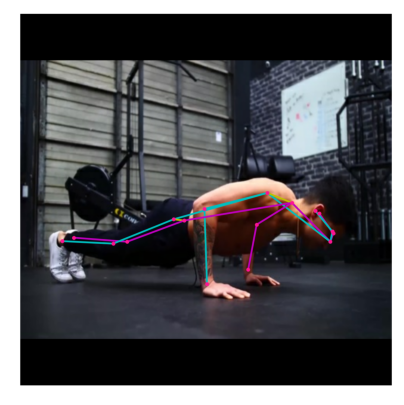

In [10]:
# Load the input image.
image = tf.io.read_file(df_keypoints['img_pth'][0])
image = tf.image.decode_jpeg(image)

# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

# Run model inference.
keypoints_with_scores = movenet(input_image)

# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

plt.figure(figsize=(5, 5))
plt.imshow(output_overlay)
_ = plt.axis('off')

In [11]:
df_keypoints

,img_pth,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,label
0,/kaggle/working/data/push up/push up_1500031.jpg,0.834935,0.612960,0.842849,0.590760,0.840664,0.585663,0.804840,0.536586,0.794672,...,0.552691,0.287529,0.613196,0.250095,0.618239,0.144195,0.602259,0.113120,0.611537,push up
1,/kaggle/working/data/push up/push up_5400341.jpg,0.243777,0.411949,0.264315,0.390220,0.225248,0.395159,0.291013,0.353517,0.199207,...,0.463143,0.328155,0.581847,0.194764,0.578792,0.283062,0.654461,0.242426,0.623935,push up
2,/kaggle/working/data/push up/push up_900071.jpg,0.255910,0.620777,0.235167,0.609069,0.236749,0.606866,0.233629,0.569551,0.235643,...,0.568359,0.740004,0.673525,0.743804,0.635214,0.935681,0.732518,0.924214,0.698513,push up
3,/kaggle/working/data/push up/push up_5300161.jpg,0.192170,0.528741,0.188084,0.502461,0.188619,0.501028,0.232944,0.473497,0.231670,...,0.543263,0.704508,0.672356,0.662312,0.659199,0.846161,0.726086,0.818310,0.716618,push up
4,/kaggle/working/data/push up/push up_5600041.jpg,0.672917,0.565330,0.697921,0.527450,0.654934,0.537197,0.722703,0.499461,0.623261,...,0.665082,0.735245,0.669396,0.662038,0.674492,0.723637,0.705074,0.683983,0.696537,push up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1338,/kaggle/working/data/squat/squat_200021.jpg,0.410656,0.473595,0.417746,0.451408,0.403753,0.453778,0.454560,0.423731,0.424377,...,0.638602,0.495516,0.764257,0.422660,0.741337,0.511886,0.866275,0.456325,0.861836,squat
1339,/kaggle/working/data/squat/squat_200081.jpg,0.416475,0.350621,0.417543,0.327924,0.404587,0.333777,0.447814,0.286889,0.420801,...,0.576806,0.533762,0.738564,0.464785,0.732084,0.535542,0.869004,0.474858,0.860110,squat
1340,/kaggle/working/data/squat/squat_2000101.jpg,0.462536,0.288333,0.478579,0.276151,0.442882,0.278384,0.502586,0.298637,0.425116,...,0.666723,0.596077,0.804972,0.343166,0.804047,-1.000000,-1.000000,-1.000000,-1.000000,squat
1341,/kaggle/working/data/squat/squat_600241.jpg,0.479174,0.499431,0.489683,0.485490,0.469215,0.485674,0.496857,0.475438,0.451531,...,0.703211,0.548216,0.806432,0.446783,0.818848,0.535482,0.878936,0.446883,0.873362,squat


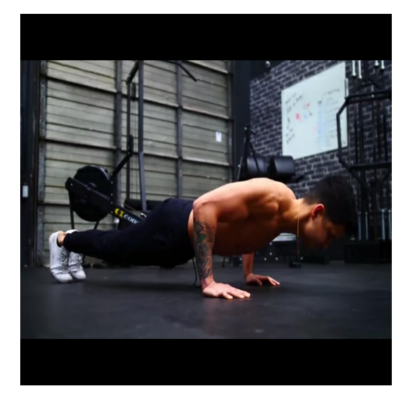

In [12]:
# lets visualize the keypoints on the image in first row

image = tf.io.read_file(df_keypoints['img_pth'][0])
image = tf.image.decode_jpeg(image)

# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

# get the keypoints from the dataframe
keypoints_with_scores = np.zeros((1,1,17,3))
keypoints_with_scores[0,0,0,1] = df_keypoints['nose_x'][0]
keypoints_with_scores[0,0,0,0] = df_keypoints['nose_y'][0]
keypoints_with_scores[0,0,1,1] = df_keypoints['left_eye_x'][0]
keypoints_with_scores[0,0,1,0] = df_keypoints['left_eye_y'][0]
keypoints_with_scores[0,0,2,1] = df_keypoints['right_eye_x'][0]
keypoints_with_scores[0,0,2,0] = df_keypoints['right_eye_y'][0]
keypoints_with_scores[0,0,3,1] = df_keypoints['left_ear_x'][0]
keypoints_with_scores[0,0,3,0] = df_keypoints['left_ear_y'][0]
keypoints_with_scores[0,0,4,1] = df_keypoints['right_ear_x'][0]
keypoints_with_scores[0,0,4,0] = df_keypoints['right_ear_y'][0]
keypoints_with_scores[0,0,5,1] = df_keypoints['left_shoulder_x'][0]
keypoints_with_scores[0,0,5,0] = df_keypoints['left_shoulder_y'][0]
keypoints_with_scores[0,0,6,1] = df_keypoints['right_shoulder_x'][0]
keypoints_with_scores[0,0,6,0] = df_keypoints['right_shoulder_y'][0]
keypoints_with_scores[0,0,7,1] = df_keypoints['left_elbow_x'][0]
keypoints_with_scores[0,0,7,0] = df_keypoints['left_elbow_y'][0]
keypoints_with_scores[0,0,8,1] = df_keypoints['right_elbow_x'][0]
keypoints_with_scores[0,0,8,0] = df_keypoints['right_elbow_y'][0]
keypoints_with_scores[0,0,9,1] = df_keypoints['left_wrist_x'][0]
keypoints_with_scores[0,0,9,0] = df_keypoints['left_wrist_y'][0]
keypoints_with_scores[0,0,10,1] = df_keypoints['right_wrist_x'][0]
keypoints_with_scores[0,0,10,0] = df_keypoints['right_wrist_y'][0]
keypoints_with_scores[0,0,11,1] = df_keypoints['left_hip_x'][0]
keypoints_with_scores[0,0,11,0] = df_keypoints['left_hip_y'][0]
keypoints_with_scores[0,0,12,1] = df_keypoints['right_hip_x'][0]
keypoints_with_scores[0,0,12,0] = df_keypoints['right_hip_y'][0]
keypoints_with_scores[0,0,13,1] = df_keypoints['left_knee_x'][0]
keypoints_with_scores[0,0,13,0] = df_keypoints['left_knee_y'][0]
keypoints_with_scores[0,0,14,1] = df_keypoints['right_knee_x'][0]
keypoints_with_scores[0,0,14,0] = df_keypoints['right_knee_y'][0]
keypoints_with_scores[0,0,15,1] = df_keypoints['left_ankle_x'][0]
keypoints_with_scores[0,0,15,0] = df_keypoints['left_ankle_y'][0]
keypoints_with_scores[0,0,16,1] = df_keypoints['right_ankle_x'][0]
keypoints_with_scores[0,0,16,0] = df_keypoints['right_ankle_y'][0]

# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

plt.figure(figsize=(5, 5))
plt.imshow(output_overlay)
_ = plt.axis('off')


In [13]:
# from points in the data frame we will draw first row skeleton
# get the points
points = df_keypoints.iloc[0,1:-1].values.reshape(-1,2)
points


array([[0.8349354267120361, 0.6129599213600159],
       [0.8428486585617065, 0.5907604098320007],
       [0.8406636714935303, 0.5856634974479675],
       [0.8048403263092041, 0.5365864634513855],
       [0.794671893119812, 0.5301759839057922],
       [0.7314907908439636, 0.5083025693893433],
       [0.6652591228485107, 0.4815642535686493],
       [0.6364173889160156, 0.5671253800392151],
       [0.4960097074508667, 0.5246667861938477],
       [0.613781213760376, 0.6876747012138367],
       [0.5027661919593811, 0.7266371846199036],
       [0.4410601556301117, 0.5560997128486633],
       [0.41284072399139404, 0.552690863609314],
       [0.28752875328063965, 0.6131958961486816],
       [0.2500954568386078, 0.6182385683059692],
       [0.14419478178024292, 0.6022585034370422],
       [0.11311981081962585, 0.6115368604660034]], dtype=object)

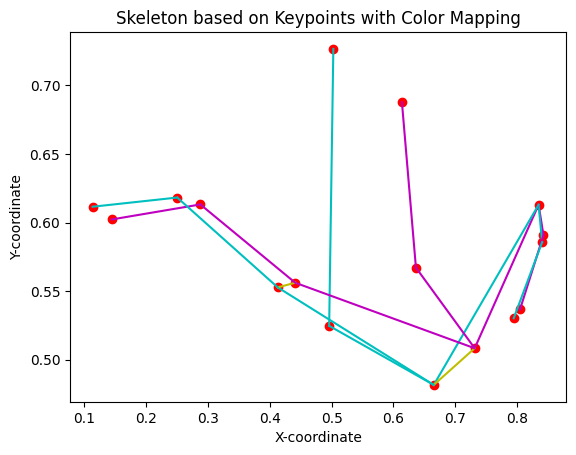

In [14]:
import matplotlib.pyplot as plt

# Reshape the points array
points = points.reshape(-1, 2)

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

# Define the connections between keypoints to draw the skeleton
connections = KEYPOINT_EDGE_INDS_TO_COLOR.keys()
# Plot the keypoints
plt.scatter(points[:, 0], points[:, 1], color='red')

# Draw skeleton connections with specified colors
for connection in connections:
    color = KEYPOINT_EDGE_INDS_TO_COLOR.get(connection, 'green')  # Default to green if color not specified
    plt.plot([points[connection[0], 0], points[connection[1], 0]],
             [points[connection[0], 1], points[connection[1], 1]], color=color)

plt.title('Skeleton based on Keypoints with Color Mapping')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.show()


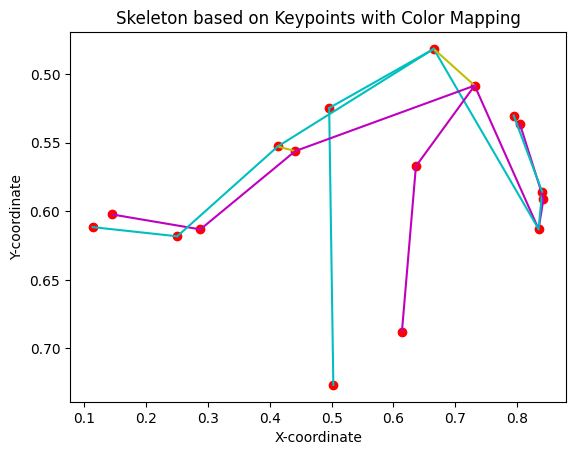

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Reshape the points array
points = points.reshape(-1, 2)

# Filter points with both x and y not equal to -1
valid_indices = np.where((points[:, 0] != -1) & (points[:, 1] != -1))[0]
valid_points = points[valid_indices]

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

# Define the connections between keypoints to draw the skeleton
connections = KEYPOINT_EDGE_INDS_TO_COLOR.keys()


# Plot the valid keypoints
plt.scatter(valid_points[:, 0], valid_points[:, 1], color='red')

# Draw skeleton connections with specified colors for valid points
for connection in connections:
    i, j = connection
    if i in valid_indices and j in valid_indices:
        color = KEYPOINT_EDGE_INDS_TO_COLOR.get(connection, 'green')  # Default to green if color not specified
        plt.plot([valid_points[i, 0], valid_points[j, 0]],
                 [valid_points[i, 1], valid_points[j, 1]], color=color)

plt.title('Skeleton based on Keypoints with Color Mapping')
plt.xlabel('X-coordinate')
plt.gca().invert_yaxis()
plt.ylabel('Y-coordinate')
plt.show()


In [16]:
from sklearn.model_selection import train_test_split
df_keypoints = pd.read_csv('/kaggle/working/keypoints.csv')
X = df_keypoints.drop(['img_pth','label'], axis=1)
y = df_keypoints['label']
id2label = {
'push up':0,
'squat':1,
}
y = y.map(id2label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,)

In [17]:
X_train.shape

(1074, 34)

In [18]:
# build the model using tensorflow and we will use embedding layer to learn the features
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten
from tensorflow.keras.callbacks import EarlyStopping

input_length = X_train.shape[1]

model = Sequential()
model.add(Embedding(input_dim=34, output_dim=16, input_length=input_length))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 16)            544       
                                                                 
 flatten (Flatten)           (None, 544)               0         
                                                                 
 dense (Dense)               (None, 32)                17440     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 18050 (70.51 KB)
Trainable params: 18050 (70.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=10)])


Epoch 1/100
34/34 [==============================] - 2s 10ms/step - loss: 0.6916 - accuracy: 0.5363 - val_loss: 0.6838 - val_accuracy: 0.5836
Epoch 2/100
34/34 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.5438 - val_loss: 0.6849 - val_accuracy: 0.5836
Epoch 3/100
34/34 [==============================] - 0s 4ms/step - loss: 0.6861 - accuracy: 0.5493 - val_loss: 0.6785 - val_accuracy: 0.5836
Epoch 4/100
34/34 [==============================] - 0s 4ms/step - loss: 0.6879 - accuracy: 0.5475 - val_loss: 0.6819 - val_accuracy: 0.5836
Epoch 5/100
34/34 [==============================] - 0s 4ms/step - loss: 0.6864 - accuracy: 0.5391 - val_loss: 0.6794 - val_accuracy: 0.5836
Epoch 6/100
34/34 [==============================] - 0s 4ms/step - loss: 0.6837 - accuracy: 0.5372 - val_loss: 0.6766 - val_accuracy: 0.5836
Epoch 7/100
34/34 [==============================] - 0s 4ms/step - loss: 0.6794 - accuracy: 0.5456 - val_loss: 0.6666 - val_accuracy: 0.5836
Epoch 8/100


In [20]:
from tensorflow.keras.models import Model

embeddings_model = Model(inputs=model.input, outputs=model.layers[0].output)


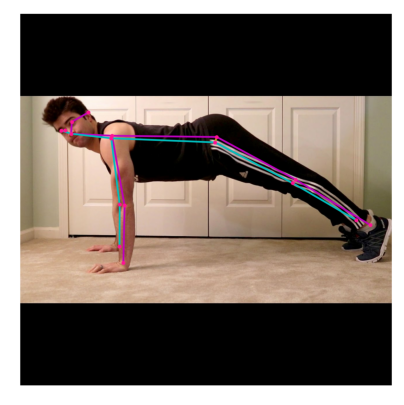

In [21]:
# Load the input image.
image_path = '/kaggle/input/wrong-push/maxresdefault.jpg'
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)

# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

# get the infoa
keypoints_with_scores = movenet(input_image)

# test
test_dict_keypoints = {
    'nose_x':[],
    'nose_y':[],
    'left_eye_x':[],
    'left_eye_y':[],
    'right_eye_x':[],
    'right_eye_y':[],
    'left_ear_x':[],
    'left_ear_y':[],
    'right_ear_x':[],
    'right_ear_y':[],
    'left_shoulder_x':[],
    'left_shoulder_y':[],
    'right_shoulder_x':[],
    'right_shoulder_y':[],
    'left_elbow_x':[],
    'left_elbow_y':[],
    'right_elbow_x':[],
    'right_elbow_y':[],
    'left_wrist_x':[],
    'left_wrist_y':[],
    'right_wrist_x':[],
    'right_wrist_y':[],
    'left_hip_x':[],
    'left_hip_y':[],
    'right_hip_x':[],
    'right_hip_y':[],
    'left_knee_x':[],
    'left_knee_y':[],
    'right_knee_x':[],
    'right_knee_y':[],
    'left_ankle_x':[],
    'left_ankle_y':[],
    'right_ankle_x':[],
    'right_ankle_y':[],
}

test_dict_keypoints['nose_x'].append(keypoints_with_scores[0,0,0,1])
test_dict_keypoints['nose_y'].append(keypoints_with_scores[0,0,0,0])
test_dict_keypoints['left_eye_x'].append(keypoints_with_scores[0,0,1,1])
test_dict_keypoints['left_eye_y'].append(keypoints_with_scores[0,0,1,0])
test_dict_keypoints['right_eye_x'].append(keypoints_with_scores[0,0,2,1])
test_dict_keypoints['right_eye_y'].append(keypoints_with_scores[0,0,2,0])
test_dict_keypoints['left_ear_x'].append(keypoints_with_scores[0,0,3,1])
test_dict_keypoints['left_ear_y'].append(keypoints_with_scores[0,0,3,0])
test_dict_keypoints['right_ear_x'].append(keypoints_with_scores[0,0,4,1])
test_dict_keypoints['right_ear_y'].append(keypoints_with_scores[0,0,4,0])
test_dict_keypoints['left_shoulder_x'].append(keypoints_with_scores[0,0,5,1])
test_dict_keypoints['left_shoulder_y'].append(keypoints_with_scores[0,0,5,0])
test_dict_keypoints['right_shoulder_x'].append(keypoints_with_scores[0,0,6,1])
test_dict_keypoints['right_shoulder_y'].append(keypoints_with_scores[0,0,6,0])
test_dict_keypoints['left_elbow_x'].append(keypoints_with_scores[0,0,7,1])
test_dict_keypoints['left_elbow_y'].append(keypoints_with_scores[0,0,7,0])
test_dict_keypoints['right_elbow_x'].append(keypoints_with_scores[0,0,8,1])
test_dict_keypoints['right_elbow_y'].append(keypoints_with_scores[0,0,8,0])
test_dict_keypoints['left_wrist_x'].append(keypoints_with_scores[0,0,9,1])
test_dict_keypoints['left_wrist_y'].append(keypoints_with_scores[0,0,9,0])
test_dict_keypoints['right_wrist_x'].append(keypoints_with_scores[0,0,10,1])
test_dict_keypoints['right_wrist_y'].append(keypoints_with_scores[0,0,10,0])
test_dict_keypoints['left_hip_x'].append(keypoints_with_scores[0,0,11,1])
test_dict_keypoints['left_hip_y'].append(keypoints_with_scores[0,0,11,0])
test_dict_keypoints['right_hip_x'].append(keypoints_with_scores[0,0,12,1])
test_dict_keypoints['right_hip_y'].append(keypoints_with_scores[0,0,12,0])
test_dict_keypoints['left_knee_x'].append(keypoints_with_scores[0,0,13,1])
test_dict_keypoints['left_knee_y'].append(keypoints_with_scores[0,0,13,0])
test_dict_keypoints['right_knee_x'].append(keypoints_with_scores[0,0,14,1])
test_dict_keypoints['right_knee_y'].append(keypoints_with_scores[0,0,14,0])
test_dict_keypoints['left_ankle_x'].append(keypoints_with_scores[0,0,15,1])
test_dict_keypoints['left_ankle_y'].append(keypoints_with_scores[0,0,15,0])
test_dict_keypoints['right_ankle_x'].append(keypoints_with_scores[0,0,16,1])
test_dict_keypoints['right_ankle_y'].append(keypoints_with_scores[0,0,16,0])

# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

plt.figure(figsize=(5, 5))
plt.imshow(output_overlay)
_ = plt.axis('off')

In [22]:
test_df = pd.DataFrame(test_dict_keypoints)
test_df.head(1)

,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
0,0.136858,0.322246,0.138634,0.290278,0.11026,0.313507,0.183046,0.265024,0.120423,0.313203,...,0.524215,0.34553,0.741389,0.445735,0.733291,0.454998,0.942274,0.567999,0.904812,0.554975


In [23]:
test_emb = embeddings_model.predict(test_df)

1/1 [==============================] - 0s 67ms/step


In [24]:
test_emb.shape

(1, 34, 16)

In [25]:
X.head(1)
x_tensor = tf.constant(X.head(1), dtype=tf.float32)


In [26]:
test_df.head(1)
test_df_tensor = tf.constant(test_df.head(1), dtype=tf.float32)


In [27]:
cosine_loss = tf.keras.losses.CosineSimilarity(axis=1)
sim = cosine_loss(test_df_tensor, test_df_tensor).numpy()*-1
sim 

0.9999998807907104

In [28]:
df_keypoints

,img_pth,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,label
0,/kaggle/working/data/push up/push up_1500031.jpg,0.834935,0.612960,0.842849,0.590760,0.840664,0.585663,0.804840,0.536586,0.794672,...,0.552691,0.287529,0.613196,0.250095,0.618239,0.144195,0.602259,0.113120,0.611537,push up
1,/kaggle/working/data/push up/push up_5400341.jpg,0.243777,0.411949,0.264315,0.390220,0.225248,0.395159,0.291013,0.353517,0.199207,...,0.463143,0.328155,0.581847,0.194764,0.578792,0.283062,0.654461,0.242426,0.623935,push up
2,/kaggle/working/data/push up/push up_900071.jpg,0.255910,0.620777,0.235167,0.609069,0.236749,0.606866,0.233629,0.569551,0.235643,...,0.568359,0.740004,0.673525,0.743804,0.635214,0.935681,0.732518,0.924214,0.698513,push up
3,/kaggle/working/data/push up/push up_5300161.jpg,0.192170,0.528741,0.188084,0.502461,0.188619,0.501028,0.232944,0.473497,0.231670,...,0.543263,0.704508,0.672356,0.662312,0.659199,0.846161,0.726086,0.818310,0.716618,push up
4,/kaggle/working/data/push up/push up_5600041.jpg,0.672917,0.565330,0.697921,0.527450,0.654934,0.537197,0.722703,0.499461,0.623261,...,0.665082,0.735245,0.669396,0.662038,0.674492,0.723637,0.705074,0.683983,0.696537,push up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1338,/kaggle/working/data/squat/squat_200021.jpg,0.410656,0.473595,0.417746,0.451408,0.403753,0.453778,0.454560,0.423731,0.424377,...,0.638602,0.495516,0.764257,0.422660,0.741337,0.511886,0.866275,0.456325,0.861836,squat
1339,/kaggle/working/data/squat/squat_200081.jpg,0.416475,0.350621,0.417543,0.327924,0.404587,0.333777,0.447814,0.286889,0.420801,...,0.576806,0.533762,0.738564,0.464785,0.732084,0.535542,0.869004,0.474858,0.860110,squat
1340,/kaggle/working/data/squat/squat_2000101.jpg,0.462536,0.288333,0.478579,0.276151,0.442882,0.278384,0.502586,0.298637,0.425116,...,0.666723,0.596077,0.804972,0.343166,0.804047,-1.000000,-1.000000,-1.000000,-1.000000,squat
1341,/kaggle/working/data/squat/squat_600241.jpg,0.479174,0.499431,0.489683,0.485490,0.469215,0.485674,0.496857,0.475438,0.451531,...,0.703211,0.548216,0.806432,0.446783,0.818848,0.535482,0.878936,0.446883,0.873362,squat


In [29]:
test_df_tensor.shape

TensorShape([1, 34])

In [30]:
x_tensor.shape

TensorShape([1, 34])

In [31]:
dict_img_sim = {
    'img_pth':[],
    'similarity':[]
}
for index, row in tqdm(df_keypoints.iterrows()):
    dict_img_sim['img_pth'].append(row['img_pth'])
    x = row.drop(['img_pth', 'label'])
    x_tensor = tf.constant(x, dtype=tf.float32)
    x_tensor = tf.expand_dims(x_tensor,axis=0)
#     print(x_tensor.shape)
    sim = cosine_loss(x_tensor, test_df_tensor).numpy()*-1
    dict_img_sim['similarity'].append(sim)


1343it [00:04, 312.81it/s]


In [32]:
df_sim = pd.DataFrame(dict_img_sim)
df_sim.describe()

,similarity
count,1343.000000
mean,0.711275
std,0.315812
min,-0.241768
25%,0.663712
50%,0.860363
75%,0.892888
max,0.991355


In [34]:
df_sim[df_sim['similarity']>=0.99135]['img_pth'].values

array(['/kaggle/working/data/push up/push up_g5.jpg'], dtype=object)

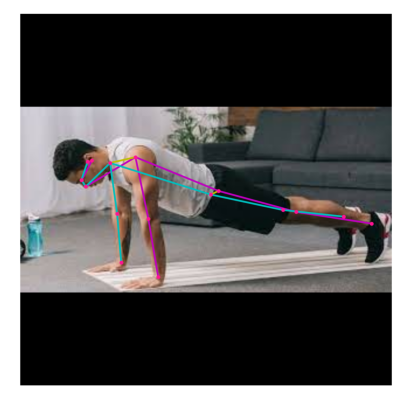

In [40]:
# Load the input image.
image_path = df_sim[df_sim['similarity']>=0.99135]['img_pth'].values[0]
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)

# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

# get the infoa
keypoints_with_scores = movenet(input_image)
correct_dict_keypoints = {
    'nose_x':[],
    'nose_y':[],
    'left_eye_x':[],
    'left_eye_y':[],
    'right_eye_x':[],
    'right_eye_y':[],
    'left_ear_x':[],
    'left_ear_y':[],
    'right_ear_x':[],
    'right_ear_y':[],
    'left_shoulder_x':[],
    'left_shoulder_y':[],
    'right_shoulder_x':[],
    'right_shoulder_y':[],
    'left_elbow_x':[],
    'left_elbow_y':[],
    'right_elbow_x':[],
    'right_elbow_y':[],
    'left_wrist_x':[],
    'left_wrist_y':[],
    'right_wrist_x':[],
    'right_wrist_y':[],
    'left_hip_x':[],
    'left_hip_y':[],
    'right_hip_x':[],
    'right_hip_y':[],
    'left_knee_x':[],
    'left_knee_y':[],
    'right_knee_x':[],
    'right_knee_y':[],
    'left_ankle_x':[],
    'left_ankle_y':[],
    'right_ankle_x':[],
    'right_ankle_y':[],
}

correct_dict_keypoints['nose_x'].append(keypoints_with_scores[0,0,0,1])
correct_dict_keypoints['nose_y'].append(keypoints_with_scores[0,0,0,0])
correct_dict_keypoints['left_eye_x'].append(keypoints_with_scores[0,0,1,1])
correct_dict_keypoints['left_eye_y'].append(keypoints_with_scores[0,0,1,0])
correct_dict_keypoints['right_eye_x'].append(keypoints_with_scores[0,0,2,1])
correct_dict_keypoints['right_eye_y'].append(keypoints_with_scores[0,0,2,0])
correct_dict_keypoints['left_ear_x'].append(keypoints_with_scores[0,0,3,1])
correct_dict_keypoints['left_ear_y'].append(keypoints_with_scores[0,0,3,0])
correct_dict_keypoints['right_ear_x'].append(keypoints_with_scores[0,0,4,1])
correct_dict_keypoints['right_ear_y'].append(keypoints_with_scores[0,0,4,0])
correct_dict_keypoints['left_shoulder_x'].append(keypoints_with_scores[0,0,5,1])
correct_dict_keypoints['left_shoulder_y'].append(keypoints_with_scores[0,0,5,0])
correct_dict_keypoints['right_shoulder_x'].append(keypoints_with_scores[0,0,6,1])
correct_dict_keypoints['right_shoulder_y'].append(keypoints_with_scores[0,0,6,0])
correct_dict_keypoints['left_elbow_x'].append(keypoints_with_scores[0,0,7,1])
correct_dict_keypoints['left_elbow_y'].append(keypoints_with_scores[0,0,7,0])
correct_dict_keypoints['right_elbow_x'].append(keypoints_with_scores[0,0,8,1])
correct_dict_keypoints['right_elbow_y'].append(keypoints_with_scores[0,0,8,0])
correct_dict_keypoints['left_wrist_x'].append(keypoints_with_scores[0,0,9,1])
correct_dict_keypoints['left_wrist_y'].append(keypoints_with_scores[0,0,9,0])
correct_dict_keypoints['right_wrist_x'].append(keypoints_with_scores[0,0,10,1])
correct_dict_keypoints['right_wrist_y'].append(keypoints_with_scores[0,0,10,0])
correct_dict_keypoints['left_hip_x'].append(keypoints_with_scores[0,0,11,1])
correct_dict_keypoints['left_hip_y'].append(keypoints_with_scores[0,0,11,0])
correct_dict_keypoints['right_hip_x'].append(keypoints_with_scores[0,0,12,1])
correct_dict_keypoints['right_hip_y'].append(keypoints_with_scores[0,0,12,0])
correct_dict_keypoints['left_knee_x'].append(keypoints_with_scores[0,0,13,1])
correct_dict_keypoints['left_knee_y'].append(keypoints_with_scores[0,0,13,0])
correct_dict_keypoints['right_knee_x'].append(keypoints_with_scores[0,0,14,1])
correct_dict_keypoints['right_knee_y'].append(keypoints_with_scores[0,0,14,0])
correct_dict_keypoints['left_ankle_x'].append(keypoints_with_scores[0,0,15,1])
correct_dict_keypoints['left_ankle_y'].append(keypoints_with_scores[0,0,15,0])
correct_dict_keypoints['right_ankle_x'].append(keypoints_with_scores[0,0,16,1])
correct_dict_keypoints['right_ankle_y'].append(keypoints_with_scores[0,0,16,0])

# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

plt.figure(figsize=(5, 5))
plt.imshow(output_overlay)
_ = plt.axis('off')

In [41]:
corre_df_keypoints = pd.DataFrame(correct_dict_keypoints)
corre_df_keypoints

,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
0,0.176061,0.464642,0.165318,0.44728,0.164608,0.446648,0.192958,0.394112,0.181072,0.397916,...,0.513207,0.486237,0.74255,0.532805,0.707517,0.527687,0.946026,0.564254,0.87124,0.54559


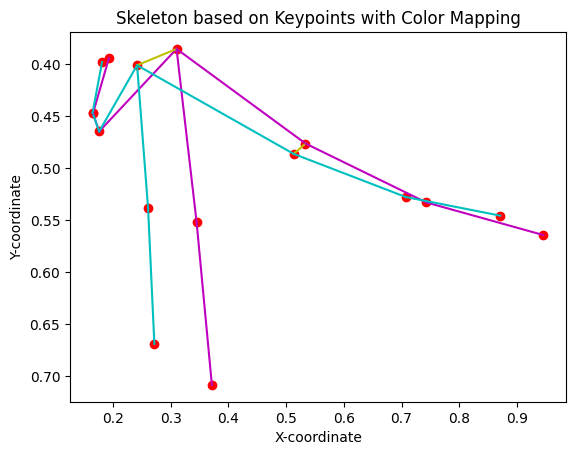

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Reshape the points array
points = corre_df_keypoints.values.reshape(-1,2)
points


points = points.reshape(-1, 2)

# Filter points with both x and y not equal to -1
valid_indices = np.where((points[:, 0] != -1) & (points[:, 1] != -1))[0]
valid_points = points[valid_indices]

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

# Define the connections between keypoints to draw the skeleton
connections = KEYPOINT_EDGE_INDS_TO_COLOR.keys()


# Plot the valid keypoints
plt.scatter(valid_points[:, 0], valid_points[:, 1], color='red')

# Draw skeleton connections with specified colors for valid points
for connection in connections:
    i, j = connection
    if i in valid_indices and j in valid_indices:
        color = KEYPOINT_EDGE_INDS_TO_COLOR.get(connection, 'green')  # Default to green if color not specified
        plt.plot([valid_points[i, 0], valid_points[j, 0]],
                 [valid_points[i, 1], valid_points[j, 1]], color=color)

plt.title('Skeleton based on Keypoints with Color Mapping')
plt.xlabel('X-coordinate')
plt.gca().invert_yaxis()
plt.ylabel('Y-coordinate')
plt.show()
